⏳ Conectando ao banco de dados...
✅ Conectado!

❄️ Listando...
❇️ Pronto!
🌟 Total de registros: 6

🐼 Baixando pixel data (X)...


☢ Processando imagens: 100%|██████████| 6/6 [00:01<00:00,  3.33img/s]



🎓 Pronto! ✅✅✅

---------- EXEMPLO [0] ----------


{'X': array([[0.        , 0.        , 0.        , ..., 0.00717918, 0.00508525,
         0.00478612],
        [0.        , 0.        , 0.        , ..., 0.00747831, 0.00658092,
         0.00568352],
        [0.        , 0.        , 0.        , ..., 0.00747831, 0.00837571,
         0.00598265],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00807658, 0.00867484,
         0.01226443],
        [0.        , 0.        , 0.        , ..., 0.00717918, 0.00897398,
         0.01076877],
        [0.        , 0.        , 0.        , ..., 0.01017051, 0.01076877,
         0.00897398]], dtype=float32),
 'Y': [{'width': 0.15606936416184974,
   'height': 0.13150289017341038,
   'x_center': 0.45723606754118784,
   'y_center': 0.5205910613506719},
  {'width': 0.16342857142857148,
   'height': 0.12571428571428567,
   'x_center': 0.8594285714285714,
   'y_center': 0.4742857142857143},
  {'width': 0.052571428571428575,
   'height': 0.04799999999999999,
   'x_center': 0.2611428571428571,
   '

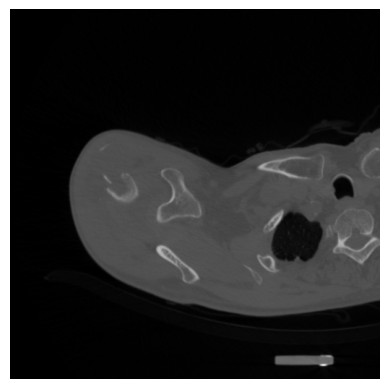

In [ ]:
!pip install pydicom

import io
from typing import Union
import requests
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sqlalchemy import create_engine, text

class YoloDataset:
  query = """
    -- PostgreSQL 15

    WITH distinct_pairs AS (
      -- 1) Somente na yolo: img_id x user_id distintos (sem join)
      SELECT DISTINCT img_id, user_id
      FROM bbox.yolo
    ),
    boxes AS (
      -- 2) Pré-agrega todas as boxes por par (ordene como preferir)
      SELECT
        img_id,
        user_id,
        jsonb_agg(
          jsonb_build_object(
            'x_center', x_center,
            'y_center', y_center,
            'width',   width,
            'height',  height
          )
          ORDER BY id
        ) AS y
      FROM bbox.yolo
      GROUP BY img_id, user_id
    )
    -- 3) Monta o JSON final
    SELECT COALESCE(
      jsonb_agg(
        jsonb_build_object(
          'metadata', jsonb_build_object(
            'img_id',   i.id,
            'img_url',  i.url,
            'user_id',  u.id,
            'user_name',u.name
          ),
          'X', NULL,                              -- JSON null
          'Y', COALESCE(b.y, '[]'::jsonb)        -- array de boxes por par
        )
      )::json,
      '[]'::json
    ) AS result
    FROM distinct_pairs dp
    JOIN bbox.img   i ON i.id = dp.img_id
    JOIN bbox.users u ON u.id = dp.user_id
    LEFT JOIN boxes b
          ON b.img_id = dp.img_id
          AND b.user_id = dp.user_id;
  """
  base_url = "https://storage.googleapis.com/doctor-yolo/"
  norm_limit = 2048

  DB_HOST="34.63.204.77"
  DB_PORT="5432"
  DB_NAME="doctor_yolo"
  DB_USER="doctor_yolo"
  DB_PASSWORD="q0qvzVgZBAx5f6HeDTyST_Rtyz22Ul1UbkcdVKOC2Fs"
  DB_SCHEMA="bbox"

  def __init__(self):
    print("⏳ Conectando ao banco de dados...")
    self.engine = create_engine(
      f"postgresql+psycopg2://{self.DB_USER}:{self.DB_PASSWORD}@{self.DB_HOST}:{self.DB_PORT}/{self.DB_NAME}",
      future=True
    )
    print("✅ Conectado!")
    print("\n❄️ Listando...")
    with self.engine.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
      conn.execute(text(f"SET search_path TO {self.DB_SCHEMA};"))
      self.data = conn.execute(text(self.query)).fetchone()[0]
    print("❇️ Pronto!")
    print("🌟 Total de registros:", len(self.data))
    print("\n🐼 Baixando pixel data (X)...")
    for row in tqdm(self.data, desc="☢ Processando imagens", unit="img"):
      row["X"] = self.getPixelData(row["metadata"]["img_url"])
    print("\n\n🎓 Pronto! ✅✅✅")

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

  def show(self, idx):
    plt.imshow(self.data[idx]["X"], cmap="gray")
    plt.axis("off")
    plt.show()

  def getPixelData(self, url):
    full_url = url if url.startswith(("http://", "https://")) else self.base_url + url.lstrip("/")
    resp = requests.get(full_url, timeout=60)
    resp.raise_for_status()
    ds = pydicom.dcmread(io.BytesIO(resp.content), force=True)
    arr = ds.pixel_array  # np.ndarray
    arr = np.ascontiguousarray(arr)
    arr = (arr/max(arr.max(), self.norm_limit)).astype(np.float32)
    return arr

# Exemplo
ds = YoloDataset()
print("\n---------- EXEMPLO [0] ----------")
display(ds[0])
ds.show(0)